# <font style="color:rgb(50,120,229)">Image Classification using Feed Forward Neural Network</font> 
In this notebook, we will use a simple feed forward neural network to peform image classification. 

Traditionally, the "hello world" example in image classification used to be a dataset called MNIST which stood for **Modified National Institute of Standards and Technology** database. It was a dataset of 60,000 training images and 10,000 testing images of hand written characters. The size of the images in the dataset was 28x28.  

With modern methods, it is very easy to achieve high accuracy on the MNIST dataset. 

Therefore, in this notebook, we have chosen to use the **Fashion MNIST** dataset which also consists of 28x28 images, but they are derived from fashion items. Like MNIST, the training set consists of 60,000 images and the test set consists of 10,000 images.

# <font style="color:rgb(50,120,229)">The Problem</font>

The figure below shows some samples from the Fashion MNIST dataset.

<img src="https://www.dropbox.com/s/m0alzz7m9c6t88u/fashion-mnist-sprite.png?dl=1" width="600">

There are 10 classes. Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


We want to perform image classification on this dataset using a feedforward neural network. The task is to train a machine learning algorithm to recognize a new sample from the test set correctly.
Here we use libtorch(https://pytorch.org/tutorials/advanced/cpp_frontend.html) for Image classification using feed forward neural network in C++. 

# <font style = "color:rgb(8,133,37)">Import Libraries</font>¶

Import required libraries and define constants like
- batchSize
- epochs
- logInterval
- Images path of train and test
- Labels path of train and test
- Torch device(To use CPU  or GPU accordingly)

```cpp
#include <stdint.h>
#include <torch/torch.h>
#include <iostream>
#include <fstream>
#include <string>
#include <vector>
#include <opencv2/core/core.hpp>
#include <opencv2/opencv.hpp>
#include <opencv2/highgui/highgui.hpp>
#include "read-mnist.h"

struct Options {
  int batchSize = 100; //Batch size
  size_t epochs = 20; // Number of epochs
  size_t logInterval = 20;
  std::ofstream loss_acc_train;
  std::ofstream loss_acc_test;
  //Paths to train and test images and labels
  const char* train_images_path = "train-images-idx3-ubyte";
  const char* train_labels_path = "train-labels-idx1-ubyte";
  const char* test_images_path = "t10k-images-idx3-ubyte";
  const char* test_labels_path = "t10k-labels-idx1-ubyte";
  torch::DeviceType device = torch::kCPU;
};

static Options options;
```

# <font style="color:rgb(50,120,229)">1. The Model</font>

We will use raw pixel values as input to the network. The images are simply matrices of size 28x28. So, we reshape the image matrix to an array of size 784 ( 28*28 ) and feed this array to the network. 

We will use a network with 2 hidden layers having 512 neurons each. 

The output layer will have 10 layers for the 10 fashion items. The schematic diagram is shown below:

<img src="https://www.learnopencv.com/wp-content/uploads/2017/10/mlp-mnist-schematic.jpg" width="700">

We use libtorch functional module(torch::nn::Module) to define the feed forward network shown above.

- **Dense Layer** 
    
        torch::nn::Linear(input_size, output_size)

All the defined layers are to be registered explicitly. Then we use forward pass through each layer and apply activation "relu" and finally apply log softmax on the output to get probabilities of all the target classes.

```cpp
//Feed Forward network
struct Net: torch::nn::Module {
    Net() {
        fc1 = register_module("fc1", torch::nn::Linear(28*28, 512));
        fc2 = register_module("fc2", torch::nn::Linear(512, 512));
        fc3 = register_module("fc3", torch::nn::Linear(512, 10));
    }

    // Implement Forward Pass Algorithm
    torch::Tensor forward(torch::Tensor x) {
        x = x.view({options.batchSize, -1});
        //Input -> Linear -> Relu -> Linear -> Relu -> Linear -> Softmax Classifier-> Output
        x = torch::relu(fc1->forward(x));
        x = torch::relu(fc2->forward(x));
        x = fc3->forward(x);
        return torch::log_softmax(x, 1);
    }

    //Initilaize the constructor with null pointer. More details given in the reference
    torch::nn::Linear fc1{nullptr}, fc2{nullptr}, fc3{nullptr};
};
```

# <font style="color:rgb(50,120,229)">2. Load the Data</font>
In libtorch, Fashion MNIST is not a built-in dataset so we need to custom load the data. This dataset is available in ubyte(eg:train-images-idx3-ubyte) format files. This format files are explained here - http://yann.lecun.com/exdb/mnist/.

We have 2 different files for images and labels in case of both train and test data. We will use Custom Dataset Class like we did for linear regression earlier to process the data and convert to tensor form. Normalization of images is also performed in read-mnist.h after tensor conversion. 

```cpp
/*Read images from ubyte format and convert to tensors*/
torch::Tensor process_images(const std::string& root, bool train) {
  const auto path = root + (train ? options.train_images_path: options.test_images_path); //images_path
  auto images = read_mnist_images(path); //refer to read-mnist.h

  return images;
}

/*Read labels from ubyte format and convert to tensors*/
torch::Tensor process_labels(const std::string& root, bool train) {
  const auto path = root + (train ? options.train_labels_path: options.test_labels_path); //labels_path
  auto labels = read_mnist_labels(path);//refer to read-mnist.h

  return labels;
}


/*Use CustomDataset class to load any type of dataset other than inbuilt datasets*/
class CustomDataset : public torch::data::datasets::Dataset<CustomDataset> {
    private:
        /* data */
        // Should be 2 tensors
        torch::Tensor images, labels;
        size_t img_size;
    public:
        CustomDataset(const std::string& root, bool train) {
            images = process_images(root, train);
            labels = process_labels(root, train);
            img_size = images.size(0);
        }
    
        /*Returns the data sample at the given `index*/
        torch::data::Example<> get(size_t index) override {
            /* This should return {torch::Tensor, torch::Tensor} */
            torch::Tensor img = images[index];
            torch::Tensor label = labels[index];
            return {img.clone(), label.clone()};
        };
    
    torch::optional<size_t> size() const override {
        return img_size;
    };
};
```

# <font style="color:rgb(50,120,229)">3. Train the Network</font>
Training data is passed in set of batches and **negative log likelihood** loss function is used to calculate the loss. Then the loss function is passed through **stochastic gradient descent** optimizer with learning rate 0.01 which is defined in the main().

Following are the major functions of training the network
- Initialize the network in training mode
    
        network->train()
- Uses negative log likelihood loss
        
        torch::nll_loss(output, targets)
- Computes the gradients in the network
        
        loss.backward()
- Updates the parameters of the network using the computed gradients
        
        optimizer.step()

```cpp
template <typename DataLoader>
void train(std::shared_ptr<Net> network, DataLoader& loader, torch::optim::Optimizer& optimizer, size_t epoch, size_t data_size) {
  size_t index = 0;
  /*Set network in the training mode*/
  network->train();
  float Loss = 0, Acc = 0;

  for (auto& batch : loader) {
    auto data = batch.data.to(options.device);
    auto targets = batch.target.to(options.device).view({-1});
    // Execute the model on the input data
    auto output = network->forward(data);

    //Using mean square error loss function to compute loss
    auto loss = torch::nll_loss(output, targets);
    auto acc = output.argmax(1).eq(targets).sum();

    // Reset gradients
    optimizer.zero_grad();
    // Compute gradients
    loss.backward();
    //Update the parameters
    optimizer.step();

    Loss += loss.template item<float>();
    Acc += acc.template item<float>();
  }

  if (index++ % options.log_interval == 0) {
  	  auto end = data_size;

      std::cout << "Train Epoch: " << epoch << " " << end << "/" << data_size
                << "\tLoss: " << Loss/end << "\tAcc: " << Acc / end
                << std::endl;
    }
};
```

# <font style="color:rgb(50,120,229)">4. Test the Model</font>
Similar to the above, the test data is passed through the trained network. Loss is calculated on test data at each epoch. After all epochs, 3 sample outputs and their ground truth are displayed.

Following are the major functions of test the network
- Initialize the network in testing mode
        
         network->eval()
- Compute negative log likelihood loss
        
         torch::nll_loss(output, targets)

```cpp
template <typename DataLoader>
void test(std::shared_ptr<Net> network, DataLoader& loader, size_t epoch, size_t data_size) {
  network->eval();
  size_t index = 0;
  float Loss = 0, Acc = 0;
  int display_count = 0;

  for (const auto& batch : loader) {
    auto data = batch.data.to(options.device);
    auto targets = batch.target.to(options.device).view({-1});

    auto output = network->forward(data);

    //To display 3 test image and its output
    if (display_count < 3 && epoch == options.epochs) {
      cv::Mat test_image(28,28,CV_8UC1);
      torch::Tensor tensor = data[display_count].mul_(255).clamp(0,255).to(torch::kU8);
      tensor = tensor.to(torch::kCPU);
      std::memcpy((void*)test_image.data,tensor.data_ptr(),sizeof(torch::kU8)*tensor.numel());

      std::cout << "***** TESTING on TEST IMAGE " << display_count << " *****" << std::endl;
      std::cout << "GroundTruth: " << targets[display_count].template item<float>()
                << ", Prediction: " << output[display_count].argmax() << std::endl;
      std::cout << "Output Probabilities" << std::endl;
      for (int i =0; i < output[display_count].size(0); i++) {
        std::cout << "Class: " << i << " " << torch::exp(output[display_count])[i].template item<float>()  << std::endl;
      }
      cv::imwrite("OUTPUT_GT_" + std::to_string(targets[display_count].template item<int>()) +
                  "_Pred_" + std::to_string(output[display_count].argmax().template item<int>()) + ".jpg", test_image);
      std::cout << "Outputs saved, Please checkout the output images" << std::endl;

      display_count++;
    }

    auto loss = torch::nll_loss(output, targets);
    auto acc = output.argmax(1).eq(targets).sum();

    Loss += loss.template item<float>();
    Acc += acc.template item<float>();
  }

  if (index++ % options.logInterval == 0) {
    options.loss_acc_test << std::to_string(Loss/data_size) + "," + std::to_string(Acc/data_size) << std::endl;
    std::cout << "Val Epoch: " << epoch
              << "\tVal Loss: " << Loss / data_size << "\tVal ACC:"<< Acc / data_size << std::endl;
  }
}

```

# <font style="color:rgb(50,120,229)">5. Main function</font>
Main function contains following steps:
- **Data Processing**
    - Data is processed within Custom Dataset Constructer and converted to tensors. Here, we already have separate
      train and test data.
          auto dataset = torch::data::datasets::MNIST("./mnist")
            .map(torch::data::transforms::Normalize<>(0.5, 0.5))
            .map(torch::data::transforms::Stack<>());
- **Data Loader**
    - This provides options for batch size, number of workers to be used to speed up the data loading.
            auto data_loader = torch::data::make_data_loader(
                std::move(dataset),
                torch::data::DataLoaderOptions().batch_size(kBatchSize).workers(2));
- **Model Initialization**
    - Define network parameters
            struct Net : torch::nn::Module {};
                void a(std::shared_ptr<Net> net) { }
                int main() {
                  auto net = std::make_shared<Net>();
                  a(net);
                }
- **Training**
    - Define the optimizer and call the train function epoch number of times and observe the loss values.
            torch::optim::Adam generator_optimizer(
            generator->parameters(), torch::optim::AdamOptions(2e-4).beta1(0.5));
            train(net, *train_loader, generator_optimizer, epoch_number, train_dataset_size);
- **Testing**
    - Call the test function in each epoch and observe the loss values.
            test(net, *test_loader, test_dataset_size);

```cpp
int main() {
    /*Path to Fashion Mnist*/
    std::string root_string = "./fashion-mnist/";
    bool isTrain = true; //Flag to create train or test data

    /*Uses Custom Dataset Class to load train data. Apply stack collation which takes 
      batch of tensors and stacks them into single tensor along the first dimension*/
    auto train_dataset = CustomDataset(root_string, isTrain).map(torch::data::transforms::Stack<>());
    /*Data Loader provides options to speed up the data loading like batch size, number of workers*/
    auto train_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
        std::move(train_dataset), options.batch_size);
    auto train_size = train_dataset.size().value();

    /*Process and load test dat similar to above*/
    auto test_dataset = CustomDataset(root_string, false).map(torch::data::transforms::Stack<>());
    auto test_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
        std::move(test_dataset), options.batch_size);
    auto test_size = test_dataset.size().value();

    /*Create Feed forward network*/
    auto net = std::make_shared<Net>();
    // torch::load(net, "net.pt"); /*To use trained model*/

    /*Using stochastic gradient descent optimizer with learning rate 0.01*/
    torch::optim::SGD optimizer(net->parameters(), 0.01); // Learning Rate 0.01

    for (size_t i = 0; i < options.iterations; i++) {
        /*Run the training for all iterations*/
        train(net, *train_loader, optimizer, i + 1, train_size);
        std::cout << std::endl;
        /*Run on the validation set for all iterations*/
        test(net, *test_loader, i+1, test_size);
        /*Save the network*/
        torch::save(net, "net.pt");
    }

    return 0;
}
```

# <font style="color:rgb(50,120,229)">6. Run inference on saved model</font>
We load the saved network to run inference on test data. Initialize the network and then use
        
       torch::load(network, path_to_network)
to load the network.

```cpp
int main() {
    /*Path to Fashion Mnist*/
    std::string root_string = "./fashion-mnist/";

    /*Process and load test dat similar to above*/
    auto test_dataset = CustomDataset(root_string, false).map(torch::data::transforms::Stack<>());
    auto test_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
        std::move(test_dataset), options.batch_size);
    auto test_size = test_dataset.size().value();

    auto net = std::make_shared<Net>();
    torch::load(net, "net.pt");
    test(net, *test_loader, options.epochs, test_size);

    return 0;
}
```

# <font style="color:blue">Steps to Compile and Run the Code on Google Colab</font>

## <font style="color:green">Download LibTorch</font>

In [1]:
!wget https://download.pytorch.org/libtorch/cu101/libtorch-shared-with-deps-1.3.1.zip -O libtorch.zip

--2020-01-04 19:08:24--  https://download.pytorch.org/libtorch/cu101/libtorch-shared-with-deps-1.3.1.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.35.7.126, 13.35.7.106, 13.35.7.18, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.7.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740942259 (707M) [application/zip]
Saving to: ‘libtorch.zip’

libtorch.zip        100%[===================>] 706.62M   112MB/s    in 6.6s    

2020-01-04 19:08:32 (107 MB/s) - ‘libtorch.zip’ saved [740942259/740942259]



In [ ]:
!unzip libtorch.zip

In [0]:
!rm -r libtorch.zip

## <font style="color:green">Download Code</font>

In [4]:
!wget "https://www.dropbox.com/s/cf0yvfzxml1x8v2/feed-forward.zip?dl=1" -O feed-forward.zip

--2020-01-04 19:08:55--  https://www.dropbox.com/s/cf0yvfzxml1x8v2/feed-forward.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cf0yvfzxml1x8v2/feed-forward.zip [following]
--2020-01-04 19:08:55--  https://www.dropbox.com/s/dl/cf0yvfzxml1x8v2/feed-forward.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce45bf2110b9aeaa6bb997b0c8d.dl.dropboxusercontent.com/cd/0/get/AvjLzW_rovLfl9VeFzR39M66Jr7bn2u6aVBF7O54RrJFT8lQUwze5U6bgNBVPz6dabkh-b6nRLDH1cc5XZIUkdRu3Ae9OiF86i6d5dDldGijlMWwKv29ofL68tJSc2b0zuM/file?dl=1# [following]
--2020-01-04 19:08:56--  https://uce45bf2110b9aeaa6bb997b0c8d.dl.dropboxusercontent.com/cd/0/get/AvjLzW_rovLfl9VeFzR39M66Jr7bn2u6aVBF7O54RrJFT8lQUwze5U6bgNBVPz6dabkh-b6nRLDH1cc5XZIUkdRu3Ae9OiF86

In [5]:
!unzip feed-forward.zip

Archive:  feed-forward.zip
   creating: feed-forward/
  inflating: feed-forward/CMakeLists.txt  
   creating: feed-forward/fashion-mnist/
  inflating: feed-forward/fashion-mnist/t10k-images-idx3-ubyte  
  inflating: feed-forward/fashion-mnist/t10k-labels-idx1-ubyte  
  inflating: feed-forward/fashion-mnist/train-images-idx3-ubyte  
  inflating: feed-forward/fashion-mnist/train-labels-idx1-ubyte  
  inflating: feed-forward/feedforward.cpp  
  inflating: feed-forward/read-mnist.h  


In [0]:
import os
os.chdir("feed-forward")

## <font style="color:green">Compile</font>

In [7]:
!cmake -DCMAKE_PREFIX_PATH=$PWD/../libtorch .

-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Looking for pthread_create
-- Looking for pthread_create - not found
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threads: TRUE  
-- Found CUDA: /usr/local/cuda (found version "10.0") 
-- Caffe2:

In [8]:
!make

Scanning dependencies of target ffnet
[ 50%] Building CXX object CMakeFiles/ffnet.dir/feedforward.cpp.o
[100%] Linking CXX executable ffnet
[100%] Built target ffnet


## <font style="color:green">Run </font>

In [9]:
!./ffnet

Running on: CUDA
Train Epoch: 1 60000/60000	Loss: 0.0155684	Acc: 0.52135

Val Epoch: 1	Val Loss: 0.00953094	Val ACC:0.6615
Train Epoch: 2 60000/60000	Loss: 0.00795719	Acc: 0.7168

Val Epoch: 2	Val Loss: 0.00726852	Val ACC:0.7348
Train Epoch: 3 60000/60000	Loss: 0.00655906	Acc: 0.772033

Val Epoch: 3	Val Loss: 0.00630846	Val ACC:0.7793
Train Epoch: 4 60000/60000	Loss: 0.00584037	Acc: 0.799617

Val Epoch: 4	Val Loss: 0.00579063	Val ACC:0.7979
Train Epoch: 5 60000/60000	Loss: 0.00539863	Acc: 0.814033

Val Epoch: 5	Val Loss: 0.00549065	Val ACC:0.8085
Train Epoch: 6 60000/60000	Loss: 0.00510948	Acc: 0.823933

Val Epoch: 6	Val Loss: 0.0052703	Val ACC:0.8147
Train Epoch: 7 60000/60000	Loss: 0.00489814	Acc: 0.83015

Val Epoch: 7	Val Loss: 0.00510668	Val ACC:0.8192
Train Epoch: 8 60000/60000	Loss: 0.00474306	Acc: 0.834617

Val Epoch: 8	Val Loss: 0.00497094	Val ACC:0.8232
Train Epoch: 9 60000/60000	Loss: 0.00461981	Acc: 0.8378

Val Epoch: 9	Val Loss: 0.00484384	Val ACC:0.8284
Train Epoch: 10 600

## <font style="color:blue">Plot Loss and Accuracy Curves using Matplotlib</font>
We will be using the matplotlib library to plot the accuracy and loss curves for visualizing how the loss and acuracy changed while training.

We had saved the loss and accuracy for training and test data while training for each epoch. We just load the data from those files and put them in a list and finally plot them.

In [0]:
with open("loss_acc_train.txt",'r') as train_file:
  train_data = train_file.readlines()
with open("loss_acc_test.txt",'r') as test_file:
  test_data = test_file.readlines()


In [0]:
train_loss_array = []
train_acc_array = []
for item in train_data:
  loss,acc = item.strip().split(',')
  train_loss_array.append(float(loss))
  train_acc_array.append(float(acc))

In [0]:
test_loss_array = []
test_acc_array = []
for item in test_data:
  loss,acc = item.strip().split(',')
  test_loss_array.append(float(loss))
  test_acc_array.append(float(acc))

In [13]:
print(train_loss_array)

[0.015568, 0.007957, 0.006559, 0.00584, 0.005399, 0.005109, 0.004898, 0.004743, 0.00462, 0.004512, 0.004435, 0.004349, 0.004274, 0.004211, 0.004144, 0.004087, 0.004031, 0.003984, 0.003941, 0.003879]


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

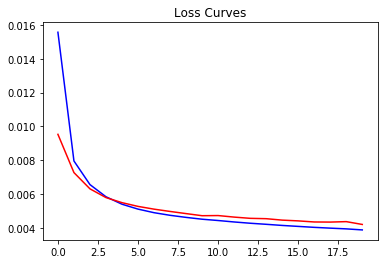

In [15]:
plt.plot(train_loss_array,'b')
plt.plot(test_loss_array,'r')
plt.title("Loss Curves");

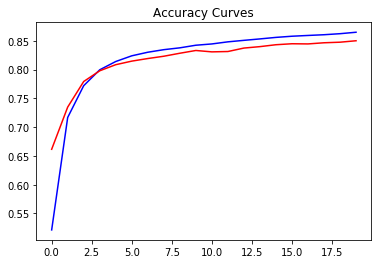

In [16]:
plt.plot(train_acc_array,'b')
plt.plot(test_acc_array,'r')
plt.title("Accuracy Curves");

References:
- https://pytorch.org/tutorials/advanced/cpp_frontend.html
- https://github.com/pytorch/examples/blob/master/cpp/custom-dataset/custom-dataset.cpp